In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import resspect
from resspect.tom_client import TomClient
from oracle_resspect_classifier.elasticc2_oracle_feature_extractor import ELAsTiCC2_ORACLEFeatureExtractor

/global/homes/a/arjun15/.conda/envs/resspect/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


In [10]:
import itertools

# code to grab objects from TOM for testing - not the most optimal way to do this but a good check for whether the feature extractor is doing its job
username = 'arjun15'
passwordfile = '../../oracle/passwordfile'

detected_in_last_days = 1
mjd_now = 60800
num_objects = 5


tom = TomClient(url="https://desc-tom-2.lbl.gov", username=username, passwordfile=passwordfile)

dic = {
    'detected_in_last_days': detected_in_last_days,
    'mjd_now': mjd_now
}

res = tom.post('elasticc2/gethottransients', json=dic)
data = res.json() if res.status_code == 200 else {}
print('=> Fetched hot transients')

ids = [obj['objectid'] for obj in data['diaobject']]
ids = ids[:num_objects] if len(ids) > num_objects else ids

# using these object ids, load in static and time series data for ORACLE
static = tom.post('db/runsqlquery/',
                json={'query': '''SELECT diaobject_id, ra, decl, mwebv, mwebv_err, z_final, z_final_err, hostgal_zphot, hostgal_zphot_err,
                hostgal_zspec, hostgal_zspec_err, hostgal_ra, hostgal_dec, hostgal_snsep, hostgal_ellipticity, hostgal_mag_u,
                hostgal_mag_g, hostgal_mag_r, hostgal_mag_i, hostgal_mag_z, hostgal_mag_y FROM elasticc2_ppdbdiaobject WHERE diaobject_id IN (%s) ORDER BY diaobject_id;''' % (', '.join(str(id) for id in ids)),
                    'subdict': {}})
static_data = static.json() if static.status_code == 200 else {}
print('=> Loaded static data...')

ts = tom.post('db/runsqlquery/',
                json={'query': 'SELECT diaobject_id, midpointtai, filtername, psflux, psfluxerr FROM elasticc2_ppdbdiaforcedsource WHERE diaobject_id IN (%s) ORDER BY diaobject_id;' % (', '.join(str(id) for id in ids)),
                    'subdict': {}})
ts_data = ts.json() if ts.status_code == 200 else {}
print('=> Loaded time-series data...') 

assert ts_data['status'] == 'ok', 'Failed to retrieve data from TOM!'

# for each object, sort all observations by MJD
ts_data['rows'].sort(key=lambda obs: obs['diaobject_id'])
grouped_ts_data = {snid: list(obj) for snid, obj in itertools.groupby(ts_data['rows'], key=lambda obs: obs['diaobject_id'])}

for observation in grouped_ts_data.values():
    observation.sort(key=lambda obs: obs['midpointtai'])

print(ts_data)
print(static_data)

FileNotFoundError: [Errno 2] No such file or directory: '../../oracle/passwordfile'

In [2]:
import polars as pl

nersc_parquet_files = '/global/cfs/cdirs/desc-td/ELASTICC2_TRAIN02_parquet'
parquet_example = os.path.join(nersc_parquet_files, 'uLens-Single_PyLIMA.parquet')
parquet = pl.read_parquet(parquet_example)

In [3]:
example_input = parquet[:1000]
example_input

SNID,MJD,BAND,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,SKY_SIG,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,SIM_MAGOBS,RA,DEC,SNTYPE,NOBS,PTROBS_MIN,PTROBS_MAX,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,REDSHIFT_FINAL,REDSHIFT_FINAL_ERR,VPEC,VPEC_ERR,HOSTGAL_NMATCH,HOSTGAL_NMATCH2,HOSTGAL_OBJID,HOSTGAL_FLAG,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,…,SIM_NOBS_UNDEFINED,SIM_SEARCHEFF_MASK,SIM_REDSHIFT_HELIO,SIM_REDSHIFT_CMB,SIM_REDSHIFT_HOST,SIM_REDSHIFT_FLAG,SIM_VPEC,SIM_HOSTLIB_GALID,SIM_DLMU,SIM_LENSDMU,SIM_RA,SIM_DEC,SIM_MWEBV,SIM_PEAKMJD,SIM_MJD_EXPLODE,SIM_MAGSMEAR_COH,SIM_AV,SIM_RV,SIM_PEAKMAG_u,SIM_PEAKMAG_g,SIM_PEAKMAG_r,SIM_PEAKMAG_i,SIM_PEAKMAG_z,SIM_PEAKMAG_Y,SIM_TEMPLATEMAG_u,SIM_TEMPLATEMAG_g,SIM_TEMPLATEMAG_r,SIM_TEMPLATEMAG_i,SIM_TEMPLATEMAG_z,SIM_TEMPLATEMAG_Y,SIM_EXPOSURE_u,SIM_EXPOSURE_g,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_SUBSAMPLE_INDEX
i64,list[f64],list[str],list[i32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],f64,f64,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i64,i16,f32,f32,f32,f32,f64,…,i32,i32,f32,f32,f32,i16,f32,i64,f32,f32,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16
6822,"[60282.3227, 60301.2301, … 61374.3313]","[""Y"", ""Y"", … ""z""]","[0, 0, … 4096]","[-9.0, -9.0, … -9.0]","[-94.544563, -117.006897, … -136.019852]","[32.231182, 35.481419, … 16.453476]","[1.75, 2.02, … 1.56]","[44.75, 45.169998, … 52.189999]","[0.25, 0.25, … 0.25]","[30.07, 30.08, … 31.01]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[18.536329, 18.540855, … 18.620668]",107.736924,3.638007,87,279,1,279,0.24554,0.012277,-9.0,-9.0,-9.0,-9.0,0.0,0.0,0,0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,…,0,3,0.0,0.0,0.0,1,0.0,-9,0.0,0.0,107.736923,3.638007,0.228685,60064.667969,-9.0,0.0,-9.0,-9.0,21.133244,19.642252,18.978964,18.737324,18.603561,18.534151,21.108442,19.617424,18.954163,18.712763,18.578733,18.50935,1.0,1.0,1.0,1.0,1.0,1.0,-9
19481,"[60397.4011, 60425.3497, … 61317.0427]","[""Y"", ""Y"", … ""z""]","[0, 0, … 4096]","[-9.0, -9.0, … -9.0]","[4.104102, 29.269594, … 285.245178]","[30.301624, 44.42305, … 21.075605]","[1.38, 2.34, … 2.31]","[49.0, 52.720001, … 48.48]","[0.25, 0.25, … 0.25]","[30.129999, 30.129999, … 30.959999]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[18.200014, 18.200014, … 18.435423]",273.20547,-8.899468,87,268,38563,38830,1.241733,0.062087,-9.0,-9.0,-9.0,-9.0,0.0,0.0,0,0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,…,0,3,0.0,0.0,0.0,1,-0.0,-9,0.0,0.0,273.205475,-8.899467,1.296193,61364.589844,-9.0,0.0,-9.0,-9.0,23.628603,21.403513,19.875044,19.129421,18.520609,18.200014,23.628603,21.403513,19.875044,19.129421,18.520609,18.200014,1.0,1.0,1.0,1.0,1.0,1.0,-9
20085,"[60365.3162, 60365.3388, … 61157.322]","[""Y"", ""Y"", … ""z""]","[0, 0, … 0]","[-9.0, -9.0, … -9.0]","[26.552706, -18.161913, … -5.56147]","[29.69908, 26.601105, … 12.065307]","[1.82, 1.68, … 1.77]","[48.869999, 47.98, … 43.599998]","[0.25, 0.25, … 0.25]","[30.110001, 30.129999, … 31.0]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[20.311325, 20.311325, … 20.414499]",230.449158,-36.213912,87,181,21415,21595,0.184033,0.009202,-9.0,-9.0,-9.0,-9.0,0.0,0.0,0,0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,…,0,3,0.0,0.0,0.0,1,0.0,-9,0.0,0.0,230.449158,-36.213913,0.187592,60702.347656,-9.0,0.0,-9.0,-9.0,23.606701,21.689453,20.878466,20.582279,20.414499,20.311325,23.606701,21.689453,20.878466,20.582279,20.414499,20.311325,1.0,1.0,1.0,1.0,1.0,1.0,-9
27982,"[60302.3202, 60302.3301, … 61190.9952]","[""Y"", ""Y"", … ""z""]","[0, 0, … 4096]","[-9.0, -9.0, … -9.0]","[143.710999, 109.486908, … 511.516388]","[102.194069, 101.670509, … 65.424614]","[2.34, 2.35, … 2.6]","[44.18, 44.060001, … 64.410004]","[0.25, 0.25, … 0.25]","[30.030001, 30.040001, … 31.0]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[15.065407, 15.065407, … 15.074723]",156.708087,7.175472,87,323,11116,11438,0.024266,0.001213,-9.0,-9.0,-

In [4]:
# example_input = parquet[0]
additional_features = ELAsTiCC2_ORACLEFeatureExtractor._get_static_features()

def get_phot_from_parquet(parquet_rows):    
    
    data = []
    for idx, obj in enumerate(parquet_rows.iter_rows(named=True)):        
        phot_d = {}
        phot_d['objectid'] = int(obj['SNID'])
        phot_d['sncode'] = obj['SNTYPE']
        # phot_d['sncode'] = class_to_sncode[obj['ELASTICC_class']]
        phot_d['redshift'] = obj['REDSHIFT_FINAL']
        phot_d['RA'] = obj['RA']
        phot_d['DEC'] = obj['DEC']
        
        phot_d['photometry'] = {}
        phot_d['photometry']['BAND'] = obj['BAND']
        phot_d['photometry']['MJD'] = obj['MJD']
        phot_d['photometry']['FLUXCAL'] = obj['FLUXCAL']
        phot_d['photometry']['FLUXCALERR'] = obj['FLUXCALERR']
        phot_d['photometry']['PHOTFLAG'] = obj['PHOTFLAG']
        
        phot_d['additional_info'] = {}
        
        for feature in additional_features:
            phot_d[feature] = obj[feature]
        
        data.append(phot_d)
        
    return data

data_dic = get_phot_from_parquet(example_input)

In [5]:
# testing out the feature extractor
from resspect.fit_lightcurves import fit, fit_TOM
feature_extraction_method = 'oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor'
intermediate_parquet_path = '../intermediate_TOM_training_features.parquet'
final_parquet_path = '../final_TOM_training_features.parquet'

fit(
    data_dic,
    output_features_file = intermediate_parquet_path,
    feature_extractor = feature_extraction_method,
    filters = 'LSST',
    additional_info = additional_features,
    # one_code = gentypes
)

INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ../intermediate_TOM_training_features.parquet


In [6]:
# viewing the output
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 40)

sncode_to_class = {
    10: 'SNIa', 110: 'SNIa', 25: 'SNIb/c', 37: 'SNII', 12: 'SNIax', 11: 'SN91bg', 50: 'KN', 82: 'M-dwarf Flare', 84: 'Dwarf Novae', 88: 'uLens', 
    40: 'SLSN', 42: 'TDE', 45: 'ILOT', 46: 'CART', 59: 'PISN', 90: 'Cepheid', 80: 'RR Lyrae', 91: 'Delta Scuti', 83: 'EB', 60: 'AGN', 87: 'uLens',
    32: 'SNII', 31: 'SNII', 35: 'SNII', 36: 'SNII', 21: 'SNIb/c', 20: 'SNIb/c', 72: 'SLSN', 27: 'SNIb/c', 26: 'SNIb/c', 146: 'CART', 150: 'KN'
}

data = pd.read_parquet(intermediate_parquet_path)
# data = pd.read_csv('../TOM_training_features.csv', index_col=0)
print(len(data['MJD'][0]))
data['orig_sample'] = 'train'
data['type'] = np.where((data['sncode'] == 10) | (data['sncode'] == 110), 'Ia', 'non-Ia')
data['ELASTICC_class'] = sncode_to_class[int(data['sncode'].iloc[0])]
data.to_parquet(final_parquet_path, index=False)

data

279


,SNID,redshift,type,sncode,MJD,FLUXCAL,FLUXCALERR,BAND,PHOTFLAG,RA,DEC,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_ELLIPTICITY,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,orig_sample,ELASTICC_class
0,6822,-9.0,non-Ia,87,"[60282.3227, 60301.2301, 60335.148, 60335.1484...","[-94.54456329345703, -117.00689697265625, -156...","[32.23118209838867, 35.48141860961914, 41.4677...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",107.736924,3.638007,0.245540,0.012277,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9999.0,999.0,999.0,999.0,999.0,999.0,999.0,train,uLens
1,19481,-9.0,non-Ia,87,"[60397.4011, 60425.3497, 60425.3724, 60431.396...","[4.104101657867432, 29.269594192504883, -9.288...","[30.301624298095703, 44.42304992675781, 42.020...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",273.205470,-8.899468,1.241733,0.062087,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9999.0,999.0,999.0,999.0,999.0,999.0,999.0,train,uLens
2,20085,-9.0,non-Ia,87,"[60365.3162, 60365.3388, 60386.2629, 60386.286...","[26.552705764770508, -18.16191291809082, 4.773...","[29.699079513549805, 26.601104736328125, 27.20...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",230.449158,-36.213912,0.184033,0.009202,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9999.0,999.0,999.0,999.0,999.0,999.0,999.0,train,uLens
3,27982,-9.0,non-Ia,87,"[60302.3202, 60302.3301, 60303.3227, 60303.332...","[143.71099853515625, 109.48690795898438, -0.61...","[102.1940689086914, 101.6705093383789, 99.8247...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",156.708087,7.175472,0.024266,0.001213,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9999.0,999.0,999.0,999.0,999.0,999.0,999.0,train,uLens
4,30239,-9.0,non-Ia,87,"[60277.3155, 60277.3254, 60283.3297, 60301.241...","[70.78044128417969, 40.95965576171875, 15.0064...","[47.298885345458984, 46.29362487792969, 52.638...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, ...","[0, 0, 0, 0, 6144, 0, 4096, 4096, 4096, 4096, ...",128.841268,6.064556,0.039105,0.001955,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9999.0,999.0,999.0,999.0,999.0,999.0,999.0,train,uLens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6946337,-9.0,non-Ia,87,"[60282.3281, 60282.3285, 60297.2612, 60297.264...","[41.350460052490234, -21.403209686279297, 38.0...","[31.103485107421875, 33.20169448852539, 27.769...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",114.712904,8.706534,0.033795,0.001690,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9999.0,999.0,999.0,999.0,999.0,999.0,999.0,train,uLens
996,6961332,-9.0,non-Ia,87,"[60423.3509, 60423.3741, 60448.35, 60448.351, ...","[37.88202667236328, -5.35267448425293, -19.673...","[44.424190521240234, 37.87816619873047, 29.131...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",297.103514,-21.645086,0.067726,0.003386,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9999.0,999.0,999.0,999.0,999.0,999.0,999.0,train,uLens
997,6961495,-9.0,non-Ia,87,"[60483.3127, 60483.3355, 60490.3961, 60506.186...","[31.77735710144043, -31.670734405517578, 65.01...","[36.021305084228516, 30.529150009155273, 40.03...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",330.246185,0.807867,0.045770,0.002288,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9999.0,999.0,999.0,999.0,999.0,999.0,999.0,train,uLens
998,6962909,-9.0,non-Ia,87,"[60276.2757, 60301.161, 60309.3441, 60310.2786...","[29.592649459

In [7]:
# basic classifier testing before trying the full active learning loop
# part 1: prepping the data
from oracle_resspect_classifier.oracle_classifier import OracleClassifier
from oracle.custom_datasets.ELAsTiCC import ELAsTiCC_LC_Dataset, truncate_ELAsTiCC_light_curve_fractionally, custom_collate_ELAsTiCC
from functools import partial
import torch
from torch.utils.data import DataLoader

torch.set_default_device('cpu')

classifier_test = OracleClassifier(dir='../', weights_dir='/pscratch/sd/a/arjun15/')
test_dataloaders = []
# days_list = 2 ** np.arange(0, 11, 1)
fractions_list = np.linspace(0.1, 1, 10).round(decimals=1)

# currently doing this manually because the oracle.presets module that has the get_test_loaders() functions uses some hardcoded constants
generator = torch.Generator(device='cpu')

for f in fractions_list:
    test_data = ELAsTiCC_LC_Dataset(
        parquet_file_path=final_parquet_path,
        max_n_per_class=None,
        include_lc_plots=True,
    )
    test_data.transform = partial(truncate_ELAsTiCC_light_curve_fractionally, f=f)
    test_dl = DataLoader(test_data, batch_size=100, shuffle=False, collate_fn=custom_collate_ELAsTiCC, generator=generator, pin_memory=True)
    test_dataloaders.append(test_dl)

Loading model weights from /pscratch/sd/a/arjun15/
Loading dataset from ../final_TOM_training_features.parquet

Mapping ELAsTiCC classes to astrophysical classes...
Starting Dataset Transformations:
Replacing band labels with mean wavelengths...
Dropping saturations from MJD series...
Dropping saturations from FLUXCAL series...
Dropping saturations from FLUXCALERR series...
Dropping saturations from BAND series...
Removing saturations from PHOTFLAG series...
Replacing PHOTFLAG bitmask with binary values...
Subtracting time of first observation...
Replacing missing values in MWEBV series...
Replacing missing values in MWEBV_ERR series...
Replacing missing values in REDSHIFT_HELIO series...
Replacing missing values in REDSHIFT_HELIO_ERR series...
Replacing missing values in HOSTGAL_PHOTOZ series...
Replacing missing values in HOSTGAL_PHOTOZ_ERR series...
Replacing missing values in HOSTGAL_SPECZ series...
Replacing missing values in HOSTGAL_SPECZ_ERR series...
Replacing missing values in

Prediction for object 2 with 10.0% of lightcurve:          uLens
1             uLens
2                EB
3     M-dwarf Flare
4                EB
          ...      
95            uLens
96    M-dwarf Flare
97               EB
98            uLens
99               EB
Length: 100,
Prediction for object 2 with 20.0% of lightcurve:          uLens
1       Dwarf Novae
2             uLens
3             uLens
4       Dwarf Novae
          ...      
95         RR Lyrae
96               EB
97    M-dwarf Flare
98            uLens
99            uLens
Length: 100,
Prediction for object 2 with 30.0% of lightcurve:          uLens
1           Cepheid
2             uLens
3             uLens
4               AGN
          ...      
95            uLens
96      Dwarf Novae
97    M-dwarf Flare
98         RR Lyrae
99            uLens
Length: 100,
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/global/homes/a/arjun15/.conda/envs/resspect/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1547730/934117613.py", line 16, in <module>
    for index, batch in enumerate(fractional_dl):
                        ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/global/homes/a/arjun15/.conda/envs/resspect/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/global/homes/a/arjun15/.conda/envs/resspect/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/global/homes/a/arjun15/.conda/envs/resspect/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.

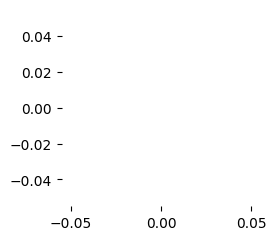

In [8]:
# part 2: running inference
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

classifier_test.model.eval()
classifier_test.model.to('cpu')

num_fractions = len(fractions_list)
batch_size = 5
figs = {}  # map batch index -> (fig, axes)

prediction_df = pd.DataFrame()

for frac, fractional_dl in zip(fractions_list, test_dataloaders):
    for index, batch in enumerate(fractional_dl):
        if index == 2:
            
            batch = {k: v.to('cpu') if torch.is_tensor(v) else v for k, v in batch.items()}
                        
            prediction_df = classifier_test.model.predict_class_probabilities_df(batch)
            print(f'Prediction for object {index} with {frac * 100}% of lightcurve: {str(prediction_df.iloc[:, 7:].idxmax(axis=1))[5:-14]}')
            
            if int(frac) == 1:
                lc_plot = torch.squeeze(batch['lc_plot'].cpu().to(torch.int32), dim=0).permute(1, 2, 0)    
                plt.imshow(lc_plot.numpy())
                
                display(prediction_df)
                # print(f'Prediction for object {index} with {frac * 100}% of lightcurve: {pred_df}')
                break

# for row_idx, (frac, fractional_dl) in enumerate(zip(fractions_list, test_dataloaders)):
#     for index, batch in enumerate(fractional_dl):
#         # batch = {k: v.to('cpu') if torch.is_tensor(v) else v for k, v in batch.items()}

#         # # Create figure for this batch index if not present
#         # if index not in figs:
#         #     fig, axes = plt.subplots(nrows=num_fractions, ncols=batch_size, figsize=(batch_size * 3, num_fractions * 3), squeeze=False)
#         #     figs[index] = (fig, axes)
#         # else:
#         #     fig, axes = figs[index]

#         # # Plot this fraction's image into the appropriate row/column
#         # for col_idx in range(batch_size):
#         #     try:
#         #         img_t = batch['lc_plot'][col_idx].permute(1, 2, 0)  # (H,W,C)
#         #         img = img_t.numpy()
#         #         ax = axes[row_idx, col_idx]
#         #         ax.imshow(img.astype(int))
#         #         ax.axis('off')
#         #         ax.set_title(f"{frac*100:.0f}%  b{index} c{col_idx}")
#         #     except Exception:
#         #         # If the batch element is missing, leave the subplot empty
#         #         ax = axes[row_idx, col_idx]
#         #         ax.axis('off')

#         # # If this is the last fraction row, display and remove the figure (column is complete)
#         # if row_idx == num_fractions - 1:
#         #     fig.tight_layout()
#         #     plt.show()
#         #     # optionally close to free memory
#         #     plt.close(fig)
#         #     del figs[index]

#         # # Run prediction for this batch if desired (move to model device)
#         demo_batch = {k: v.to(next(classifier_test.model.parameters()).device) if torch.is_tensor(v) else v for k, v in batch.items()}
#         pred_df = classifier_test.model.predict_class_probabilities_df(demo_batch)
#         print(f'Prediction for object {index} with {frac * 100}% of lightcurve: {max(pred_df)}')

In [16]:
import re
display(prediction_df)
col_name = prediction_df.iloc[:, 7:].idxmax(axis=1)
col_name_list = re.findall(r"[A-Za-z]+", str(col_name))
# print(f'{col_name}: {prediction_df[col_name]}')
# print(str(col_name))
# col_name_list
list(col_name)

,Alert,Transient,Variable,SN,Fast,Long,Periodic,AGN,SNIa,SNIb/c,SNIax,SNI91bg,SNII,KN,Dwarf Novae,uLens,M-dwarf Flare,SLSN,TDE,ILOT,CART,PISN,Cepheid,RR Lyrae,Delta Scuti,EB
0,1.0,0.996649,0.003351,2.636010e-08,0.996599,0.000051,0.001991,0.001360,4.375437e-14,3.649757e-11,3.768905e-12,2.571279e-08,6.070026e-10,5.830228e-07,0.000059,0.996539,6.587727e-08,1.209609e-05,1.603134e-09,2.715427e-06,1.701389e-07,3.553732e-05,5.374249e-07,0.001142,4.153241e-05,0.000807
1,1.0,0.167618,0.832382,3.214258e-06,0.167514,0.000100,0.830003,0.002379,2.334183e-10,6.893813e-10,6.089873e-08,3.140933e-06,1.150411e-08,2.163858e-07,0.124315,0.042840,3.589772e-04,1.993500e-06,1.642957e-06,1.622210e-05,3.297809e-06,7.672973e-05,6.521906e-01,0.159246,1.360293e-02,0.004964
2,1.0,0.997693,0.002307,1.763529e-07,0.997677,0.000016,0.002202,0.000105,1.616464e-12,1.299431e-10,6.714314e-11,1.735984e-07,2.555762e-09,2.831649e-07,0.084597,0.912338,7.421324e-04,1.199425e-05,3.286556e-07,8.430483e-07,1.051762e-06,1.735798e-06,1.097970e-06,0.000578,5.244744e-07,0.001622
3,1.0,0.999497,0.000503,1.851799e-06,0.999381,0.000114,0.000434,0.000068,4.593145e-11,2.493722e-09,2.857533e-09,1.793893e-06,5.250889e-08,1.156180e-06,0.122710,0.875782,8.889126e-04,7.773493e-05,2.502114e-06,5.274809e-06,1.665575e-05,1.185251e-05,2.655628e-07,0.000105,1.037819e-07,0.000329
4,1.0,0.439433,0.560567,7.889693e-04,0.434931,0.003712,0.043678,0.516890,4.011114e-06,7.161182e-05,1.547980e-07,5.011881e-04,2.120035e-04,7.934195e-07,0.000035,0.000117,4.347786e-01,1.656587e-04,3.533173e-03,1.213750e-05,1.226695e-06,2.566616e-07,9.772379e-08,0.000105,7.382805e-06,0.043566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.840894,0.159106,3.506020e-09,0.840863,0.000031,0.122236,0.036870,1.123692e-15,1.060444e-12,1.405134e-13,3.477995e-09,2.682332e-11,6.085077e-07,0.000043,0.840819,1.701718e-07,9.095717e-07,1.127221e-09,5.039667e-06,1.670157e-08,2.536927e-05,2.747763e-05,0.114594,4.908181e-03,0.002706
96,1.0,0.998900,0.001100,3.926323e-05,0.998826,0.000035,0.001050,0.000051,5.889177e-09,1.869929e-07,1.527983e-08,3.788904e-05,1.166029e-06,2.473976e-07,0.504816,0.008559,4.854496e-01,9.453450e-06,2.168469e-05,1.161079e-07,3.318283e-06,6.401625e-08,3.662074e-07,0.000010,1.219157e-08,0.001039
97,1.0,0.964333,0.035667,2.663892e-05,0.964203,0.000104,0.024260,0.011407,3.232904e-08,1.071227e-06,2.207729e-09,2.247157e-05,3.061578e-06,2.682810e-07,0.000574,0.001129,9.625001e-01,2.430078e-05,7.947213e-05,7.973935e-08,1.075978e-07,7.134342e-09,7.629572e-09,0.000008,1.115131e-07,0.024252
98,1.0,0.339149,0.660851,1.368348e-07,0.339123,0.000026,0.657961,0.002889,1.316944e-12,4.193420e-11,7.808794e-10,1.347677e-07,1.243060e-09,4.916361e-08,0.200160,0.137589,1.374108e-03,1.292353e-06,6.004405e-07,1.149460e-05,4.328882e-07,1.263841e-05,1.258455e-02,0.633909,2.756341e-03,0.008712


['uLens',
 'Cepheid',
 'uLens',
 'uLens',
 'AGN',
 'AGN',
 'uLens',
 'M-dwarf Flare',
 'uLens',
 'Cepheid',
 'uLens',
 'M-dwarf Flare',
 'Dwarf Novae',
 'uLens',
 'M-dwarf Flare',
 'AGN',
 'M-dwarf Flare',
 'RR Lyrae',
 'RR Lyrae',
 'M-dwarf Flare',
 'Dwarf Novae',
 'M-dwarf Flare',
 'RR Lyrae',
 'RR Lyrae',
 'uLens',
 'AGN',
 'RR Lyrae',
 'uLens',
 'uLens',
 'AGN',
 'uLens',
 'uLens',
 'uLens',
 'uLens',
 'uLens',
 'uLens',
 'uLens',
 'RR Lyrae',
 'uLens',
 'uLens',
 'uLens',
 'M-dwarf Flare',
 'Cepheid',
 'Dwarf Novae',
 'uLens',
 'M-dwarf Flare',
 'uLens',
 'uLens',
 'M-dwarf Flare',
 'AGN',
 'uLens',
 'uLens',
 'uLens',
 'RR Lyrae',
 'Dwarf Novae',
 'Dwarf Novae',
 'uLens',
 'M-dwarf Flare',
 'uLens',
 'uLens',
 'M-dwarf Flare',
 'uLens',
 'uLens',
 'uLens',
 'uLens',
 'uLens',
 'uLens',
 'uLens',
 'Dwarf Novae',
 'uLens',
 'M-dwarf Flare',
 'uLens',
 'uLens',
 'AGN',
 'uLens',
 'AGN',
 'uLens',
 'uLens',
 'M-dwarf Flare',
 'uLens',
 'RR Lyrae',
 'uLens',
 'uLens',
 'uLens',
 'EB',

In [ ]:
# do this classification for a few hundred of each object type and remake the confusion matrices to see if results match what we expect
# work on resspect PR for supporting parquet as well as csv files
# integrate classification into the full TimeDomainLoop infrastructure